** Описание **
Построить графики распределения в спам и не спам множествах следующих признаков:

•	Количество слов на странице
•	Количество слов в заголовке страниц (слова в теге <html><head><title > Some text </title>)
•	Средняя длинна слова
•	Количество слов в анкорах ссылок (<html><body><a> Some text </a>)



In [184]:
import sys
import base64
import random
import chardet
import codecs
from re import sub

from nltk.stem import SnowballStemmer
from HTMLParser import HTMLParser

stemmer = SnowballStemmer("russian");

 ** HTML Parser **
Тут мы можем распарсить страницу, выделить текст, заголовок, текст в ссылках документа

In [185]:
class SpamHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self.__text = []
        self.__titletext = []
        self.__atext = []
        self.title_tag = 0
        self.a = 0

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = sub('[ \t\r\n]+', ' ', text)
            self.__text.append(text + ' ')
            if (self.title_tag == 1):
                self.__titletext.append(text + ' ')
            if (self.a == 1):
                self.__atext.append(text + ' ')
            

    def handle_starttag(self, tag, attrs):
        #print 'all g'
        if tag == 'p':
            self.__text.append('\n\n')
        elif tag == 'br':
            self.__text.append('\n')
        elif tag == 'title':
            self.title_tag = 1
        elif tag == 'a':
            self.a = 1
        
            
    def handle_endtag(self, tag):
        if tag == 'title':
            self.title_tag = 0
        elif tag == 'a':
            self.a = 0

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self.__text.append('\n\n')


    def text(self):
        return ''.join(self.__text).strip()
    
    def titletext(self):
        return ''.join(self.__titletext).strip()
    
    def atext(self):
        return ''.join(self.__atext).strip()

** Сбор статистики **
Класс отвечает за сбор статистики

In [186]:
class Stat:
    def __init__(self):
            self.points = []
            self.spam = []
            self.notspam = []
                            
            
class StatsCollector:
    
    
    def __init__(self):
        self.total_words = Stat();
        self.header_words = Stat();
        self.average_word_length = Stat();
        self.links_words = Stat();
        
    def collect(self, mark, pageInb64, url):
            
            html = base64.b64decode(pageInb64).decode('utf-8')
            parser = SpamHTMLParser()
            parser.feed(html)

            self.total_words.points.append(len(parser.text().split(' ')))
            if (mark == 0):
                self.total_words.notspam.append(len(parser.text().split(' ')))
            elif (mark == 1):
                self.total_words.spam.append(len(parser.text().split(' ')))
            
            self.header_words.points.append(len(parser.titletext().split(' ')))
            if (mark == 0):
                self.header_words.notspam.append(len(parser.titletext().split(' ')))
            elif (mark == 1):
                self.header_words.spam.append(len(parser.titletext().split(' ')))
                
            self.links_words.points.append(len(parser.atext().split(' ')))
            if (mark == 0):
                self.links_words.notspam.append(len(parser.atext().split(' ')))
            elif (mark == 1):
                self.links_words.spam.append(len(parser.atext().split(' ')))
            parser.close()
            
            all_len = 0.0
            t = parser.text().split(' ')
            for w in t:
                all_len += len(w)
            
            self.average_word_length.points.append(int(all_len / len(t)))
            if (mark == 0):
                self.average_word_length.notspam.append(int(all_len / len(t)))
            elif (mark == 1):
                self.average_word_length.spam.append(int(all_len / len(t)))
            
 


** Обрабатываем входной файл **
Входной файл  ./data/train-set-ru-b64-utf-8.txt 
Формат - поля разделенные табуляциями
0 - идентификатор документа
1 - метка класса 0 - не спам, 1 - спам
2 - урл документа
3 - документ в кодировке base64


In [187]:
DATA_FILE  = './data/train-set-ru-b64-utf-8.txt'


stats_collector = StatsCollector()
i=0

with open (DATA_FILE) as df:
     for i, line in enumerate(df):
            line = line.strip()
            parts = line.split()
            stats_collector.collect(int(parts[1]), parts[3], parts[2])
            #print parts[1]
            #if (i == 1):
            #    break
            


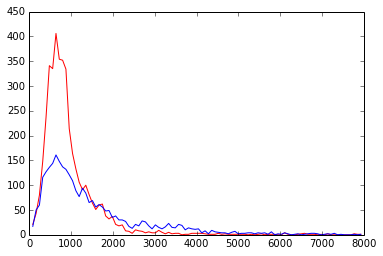

In [193]:
ys, x = np.histogram(filter(lambda x: x < 8000, stats_collector.total_words.spam), bins = 100)
yns, x = np.histogram(filter(lambda x: x < 8000, stats_collector.total_words.notspam), bins = 100)
plt.plot(x[1:], ys, c ='r')
plt.plot(x[1:], yns, c = 'b')

In [194]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def plot_stats(stat, threshold):

    stat.points = list(set(stat.points))
    stat.points = sorted(stat.points)
    x = np.asarray(stat.points)
    y_spam = []
    y_notspam = []
    pos = 0
    for p in stat.points:
        if (p > threshold):
            break
        p1 = filter(lambda x: x == p, stat.spam)
        p2 = filter(lambda x: x == p, stat.notspam)
        y_spam.append(len(p1))
        y_notspam.append(len(p2))
        pos += 1

        
    y_spam = np.asarray(y_spam)
    y_notspam = np.asarray(y_notspam)
    #print len(x) , len(y_spam), len(y_notspam)
    plt.plot(x[:pos], y_spam, c = 'r')
    plt.plot(x[:pos], y_notspam, c = 'b')
    plt.grid(True)
    plt.show()


** Тут строим графики **
1 - Количество слов в документах спам и не спам множеств
2 - Количество слов в заголовках спам и не спам множеств
3 - Средняя длина слова для спам и не спам множеств
4 - Количество слов в ссылках спам и не спам множеств

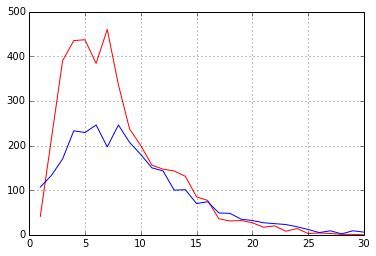

In [195]:
plot_stats(stats_collector.header_words, 30)

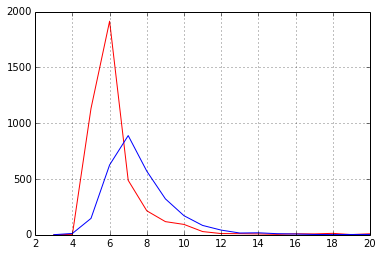

In [196]:
plot_stats(stats_collector.average_word_length, 20)

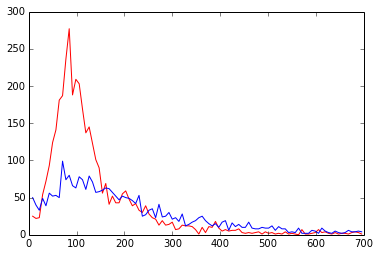

In [197]:
ys, x = np.histogram(filter(lambda x: x < 700, stats_collector.links_words.spam), bins = 100)
yns, x = np.histogram(filter(lambda x: x < 700, stats_collector.links_words.notspam), bins = 100)
plt.plot(x[1:], ys, c ='r')
plt.plot(x[1:], yns, c = 'b')